# Exercice 1 #

In [2]:
import numpy as np
from matplotlib import pyplot
from IPython.display import display, clear_output

## 1.1 ##

In [3]:
class BernoulliBandit:
    def __init__ (self, means, randomstate = None):
        self.means = means
        self.random = np.random.RandomState(randomstate)
        self.k_star = np.argmax(means)
        self.gaps = means[self.k_star] - means
        self.regret = []
        
    def get_K(self):
        return len(self.means)
    
    def play(self, action):
        self.regret.append(self.gaps[action])
        sample = self.random.rand(self.get_K())
        reward = int(sample[action] < self.means[action])
        return reward
            
    def get_cumulative_regret(self):
        return np.cumsum(self.regret)

In [4]:
def etc(bandit, T, m):
    estimates = []
    for k in range(bandit.get_K()):
        m_estimates = []
        for i in range(m):
            m_estimates.append(bandit.play(k))
        estimates.append(np.mean(m_estimates))

    k_t = np.argmax(estimates)
    for t in range(m * bandit.get_K(), T):
        r_t = bandit.play(k_t)
    return k_t

In [5]:
def etc_experiment(N, T, m, means, seed=None):
    mistakes = 0
    pseudo_regrets = []
    
    for n in range(N):
        bandit = BernoulliBandit(means, seed)
        k_t = etc(bandit, T, m)
        mistakes += (k_t != bandit.k_star)
        pseudo_regrets.append(bandit.get_cumulative_regret())

    avg_cumul_regret = np.mean(pseudo_regrets, axis=0)
    std_cumul_regret = np.std(pseudo_regrets, axis=0)
    
    return  (mistakes / N, avg_cumul_regret, std_cumul_regret)

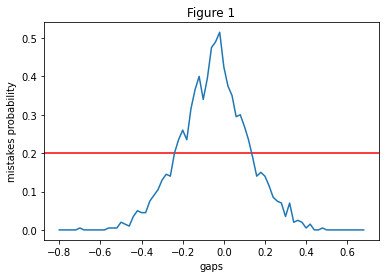

In [26]:
experiments = 75
N = 200
m = 10
T = 2 * m + 1

means = np.array([0.1, 0.9])
step = 0.01

cumul_mistakes = []
cumul_gap = []

fig = pyplot.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(experiments):
    (mistakes_mean, _, _) = etc_experiment(N, T, m, means)
    cumul_mistakes.append(mistakes_mean)
    cumul_gap.append(round(means[0] - means[1], 3))

    x = np.arange(i + 1)
    ax.set_xlim(0, i)
    ax.cla()
    ax.set_title("Experiment for " + str(means))
    ax.set_ylabel('mistakes probability')
    ax.set_xlabel(f'gaps  (current gap : {round(means[0] - means[1], 3)})')
    ax.plot(cumul_gap, cumul_mistakes)
    ax.axhline(y=0.2, color='r')
    display(fig)
    clear_output(wait = True)
    pyplot.pause(0.1)
    
    means[0] += step
    means[1] -= step
    
ax.cla()
ax.axhline(y=0.2, color='r')
ax.set_title("Figure 1")
ax.set_ylabel('mistakes probability')
ax.set_xlabel('gaps')
ax.plot(cumul_gap, cumul_mistakes)
display(fig)

## 1.2 ##

In [27]:
class NormalBandit:
    def __init__ (self, means, sigma, randomstate = None):
        self.sigma = sigma
        self.means = means
        self.random = np.random.RandomState(randomstate)
        self.k_star = np.argmax(means)
        self.gaps = means[self.k_star] - means
        self.regret = []
        
    def get_K(self):
        return len(self.means)
    
    def play(self, action):
        self.regret.append(self.gaps[action])
        return self.random.normal(self.means[action], self.sigma[action])
            
    def get_cumulative_regret(self):
        return np.cumsum(self.regret)

In [28]:
def egreedy(bandit, T, eps, init_estimator=lambda K: np.zeros(K), seed=None):
    random = np.random.RandomState(seed)
    K = bandit.get_K()
    avgs = init_estimator(K)
    plays = np.zeros(K)
    for t in range(T):
        if random.rand() < eps:
            k_t = random.choice(K)
        else:
            k_t = np.argmax(avgs)
        r_t = bandit.play(k_t)
        avgs[k_t] = (plays[k_t] * avgs[k_t] + r_t) / (plays[k_t] + 1)
        plays[k_t] += 1

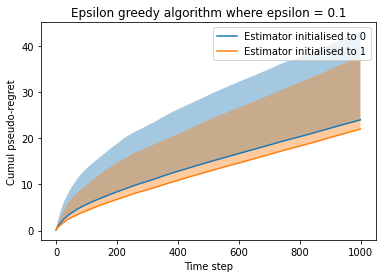

In [29]:
T = 1000
N = 500
K = 2

random = np.random.RandomState(67)

means_instance = random.rand(N, K)
sigma_instance = random.rand(N, K)

pseudo_regrets = {'zero_init': [], 'one_init': []}

for n in range(N):
    banditA = NormalBandit(means_instance[n], sigma_instance[n], randomstate=n)
    egreedy(banditA, T, 0.1, seed=n)
    pseudo_regrets["zero_init"].append(banditA.get_cumulative_regret())
    
    banditB = NormalBandit(means_instance[n], sigma_instance[n], randomstate=n)
    egreedy(banditB, T, 0.1, init_estimator=lambda K: np.full(K, 1.0), seed=n)
    pseudo_regrets["one_init"].append(banditB.get_cumulative_regret())
    

avg_cumul_regret = {
    'zero_init': np.mean(pseudo_regrets['zero_init'], axis=0), 
    'one_init': np.mean(pseudo_regrets['one_init'], axis=0)}
std_cumul_regret = {
    'zero_init': np.std(pseudo_regrets['zero_init'], axis=0), 
    'one_init': np.std(pseudo_regrets['one_init'], axis=0)}

pyplot.plot(avg_cumul_regret["zero_init"], label="Estimator initialised to 0")
pyplot.fill_between(np.arange(T), 
                    avg_cumul_regret["zero_init"], 
                    avg_cumul_regret["zero_init"] + std_cumul_regret["zero_init"], alpha=0.4)

pyplot.plot(avg_cumul_regret["one_init"], label="Estimator initialised to 1")
pyplot.fill_between(np.arange(T), 
                    avg_cumul_regret["one_init"], 
                    avg_cumul_regret["one_init"] + std_cumul_regret["one_init"], alpha=0.4)

pyplot.xlabel("Time step")
pyplot.ylabel("Cumul pseudo-regret")
pyplot.title("Epsilon greedy algorithm where epsilon = 0.1")
pyplot.legend()